In [1]:
import sys, os
sys.path.append('..')
from Data.TimeSeries import *
from ETF.AAA import *

from Data import factors
import Quandl
import pandas as pd
import matplotlib

import cvxopt as opt
from cvxopt import blas, solvers


%matplotlib inline

/Users/jianboxue/anaconda/lib/python2.7/site-packages/pandas/io/data.py:33: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


In [2]:
sector_tickers = [
            'GOOG/NYSEARCA_XLB',
            'GOOG/NYSEARCA_XLE', 
            'GOOG/NYSEARCA_XLF',
            'GOOG/NYSEARCA_XLI',
            'GOOG/NYSEARCA_XLK',
            'GOOG/NYSEARCA_XLP', 
            'GOOG/NYSEARCA_XLU', 
            'GOOG/NYSEARCA_XLV', 
            'GOOG/NYSEARCA_XLY', 
            'GOOG/NYSE_SPY', 
            'GOOG/NYSEARCA_TLT'
            ]


micai_tickers = ['GOOG/NYSE_VWO', 
                'GOOG/NYSE_VPL', 
                'GOOG/NYSE_VGK', 
                'GOOG/NYSE_VTI',
                'GOOG/NYSE_BND', #美国债券ETF
                'GOOG/AMEX_BWX', #SPDR Barclays Intl Treasury bond etf
                'GOOG/NYSEARCA_LQD', #iShares IBoXX & Invest Grade Corp Bond 
                'GOOG/NYSEARCA_EMB', #iShares JPMorgan Emerging Mkt Bond
                'GOOG/NYSE_SPY',
                'GOOG/NYSEARCA_TLT']

global_tickers = [
           #'GOOG/AMEX_EWJ', # iShares MSCI Japan ETF
           'GOOG/NYSE_IEV', # iShares Europe ETF
           'GOOG/NYSE_VWO', # Vanguard Emerging Market Stock ETF
           
           #'GOOG/NYSE_VNQ', # Vanguard MSCI US Reits
           'GOOG/NYSE_IYR', # iShares U.S. Real Estate ETF
           'GOOG/NYSE_RWX', # SPDR DJ Wilshire Intl Real Estate ETF
           
           'GOOG/NYSEARCA_TLT',  # 20 Years Treasury ETF
           'GOOG/NYSEARCA_TLH',  # 15-20 Years Treasury
           
           'GOOG/AMEX_GSG', # GSCI Commodity-Indexed Trust Fund
           'GOOG/NYSEARCA_GLD',  # SPDR Gold ETF
           'GOOG/NYSE_SPY']

ticker_bm = 'GOOG/NYSEARCA_TLT'
ticker_spy = 'GOOG/NYSE_SPY'

settings = Settings()
dp_sectors = TimeSeries(settings).get_agg_data(sector_tickers)
dp_sectors = dp_sectors.fillna(method='pad', axis=0)
dp_sectors = dp_sectors.fillna(method='bfill', axis=0)

dp_micai = TimeSeries(settings).get_agg_data(micai_tickers)
dp_micai = dp_micai.fillna(method='pad', axis=0)
dp_micai = dp_micai.fillna(method='bfill', axis=0)

dp_global = TimeSeries(settings).get_agg_data(global_tickers)
dp_global = dp_global.fillna(method='pad', axis=0)
dp_global = dp_global.fillna(method='bfill', axis=0)

## 策略1: 利用momentum的方式，确定交易信号

In [ ]:
def ETF_Momentum_Strategy(dp, ticker_bm, ticker_spy) :
    #df_prices_m = dp[:, :, 'price'].resample('20d',  label='right', closed='right')
    df_prices_m = filtering(dp[:, :, 'price'], 10)
    df_rets_m = df_prices_m.pct_change()
    
    df_str1 = pd.DataFrame()
    df_str2 = pd.DataFrame()
    df_str3 = pd.DataFrame()
    df_str4 = pd.DataFrame()

    dp_str = pd.Panel()
    dp_str['1'] = pd.DataFrame()
    dp_str['2'] = pd.DataFrame()
    dp_str['3'] = pd.DataFrame()
    dp_str['4'] = pd.DataFrame()
    dp_str['5'] = pd.DataFrame()
    dp_str['6'] = pd.DataFrame()
    dp_str['7'] = pd.DataFrame()


    df_str_d = pd.DataFrame()
    moving_win = 3
    tickers = dp.axes[0]
    for t in tickers:
        print t
        con1 = df_prices_m[t] > pd.rolling_mean(df_prices_m[t], 10)
        con2 = pd.rolling_sum(df_rets_m[t], moving_win) > pd.rolling_sum(df_rets_m[ticker_spy], moving_win)
        con3 = pd.rolling_sum(df_rets_m[t], 1) > (0.05/6)
#         con3 = pd.rolling_sum(df_rets_m[t], moving_win) > pd.rolling_sum(df_rets_m[ticker_bm], moving_win)

        con4 = con1 & con3
        con5 = con2 & con3
        con6 = con1 & con2
        con7 = con1 & con2 & con3

        dp_str['1'][t] = con1.shift(1) * df_rets_m[t]
        dp_str['2'][t] = con2.shift(1) * df_rets_m[t] 
        dp_str['3'][t] = con3.shift(1) * df_rets_m[t]
        dp_str['4'][t] = con4.shift(1) * df_rets_m[t] #dp['2'][t] + (1-con5*1).shift(1) * df_rets_m[ticker_bm]
        dp_str['5'][t] = con5.shift(1) * df_rets_m[t]
        dp_str['6'][t] = con6.shift(1) * df_rets_m[t]
        dp_str['7'][t] = con7.shift(1) * df_rets_m[t]

    #(1+df_str1).cumprod().plot(figsize=[20,12])
    df_avg = pd.DataFrame()
    df_count1 = ((dp_str['1'] <>0).shift(1)*1).sum(axis=1)
    df_count1[df_count1 == 0] = 1
    df_count2 = ((dp_str['2'] <>0).shift(1)*1).sum(axis=1)
    df_count2[df_count2 == 0] = 1
    df_count3 = ((dp_str['3'] <>0).shift(1)*1).sum(axis=1)
    df_count3[df_count3 == 0] = 1
    df_count4 = ((dp_str['4'] <>0).shift(1)*1).sum(axis=1)
    df_count4[df_count4 == 0] = 1
    df_count5 = ((dp_str['5'] <>0).shift(1)*1).sum(axis=1)
    df_count5[df_count5 == 0] = 1
    df_count6 = ((dp_str['6'] <>0).shift(1)*1).sum(axis=1)
    df_count6[df_count6 == 0] = 1
    df_count7 = ((dp_str['7'] <>0).shift(1)*1).sum(axis=1)
    df_count7[df_count7 == 0] = 1
    
    df_avg['1'] = dp_str['1'].sum(axis=1)  / df_count1.shift(1)
    df_avg['2'] = dp_str['2'].sum(axis=1)  / df_count2.shift(1)
    df_avg['3'] = dp_str['3'].sum(axis=1)  / df_count3.shift(1)
    df_avg['1_3'] = dp_str['4'].sum(axis=1)  / df_count4.shift(1)
    df_avg['2_3'] = dp_str['5'].sum(axis=1)  / df_count5.shift(1)
    df_avg['1_2'] = dp_str['6'].sum(axis=1)  / df_count6.shift(1)
    df_avg['total'] = dp_str['7'].sum(axis=1)  / df_count7.shift(1)
    df_avg['spy'] = df_rets_m[ticker_spy]
    return df_avg


class Momentum(AAA) :
    def initialize(self, context):
        add_history(200, '1d', 'price')
        set_slippage(slippage.FixedSlippage(spread=0.0))
        set_commission(commission.PerShare(cost=0.01, min_trade_cost=1.0))
        context.tick = 0

    def handle_data(self, context, data):
        rebalance_period = 20
        context.tick += 1
        
        if context.tick < 200 :
            return
        if context.tick % rebalance_period != 0:
            return

        # momentum conditons
        prices_200d = history(200, '1d', 'price').dropna()
        prices_m = filtering(prices_200d, rebalance_period)
        prices_ma_10m = pd.rolling_mean(prices_m, 10)
        con1 = prices_m.tail(1) > prices_ma_10m.tail(1)
        
        # 
        #con2 = pd.rolling_sum(df_rets_m[t], moving_win) > pd.rolling_sum(df_rets_m[ticker_spy], moving_win)
        #con3 = pd.rolling_sum(df_rets_m[t], 1) > (0.05/6)
        
        # picking up the ETF, which outperforms the SPY
        moving_win = 3
        print prices_m.loc[:, ticker_spy]
        rets_3m = (prices_m / prices_m.shift(moving_win) - 1)
        rets_spy_3m = (prices_m[ticker_spy] / prices_m[ticker_spy].shift(moving_win) - 1)
        #print rets_3m

        # Get rolling window of past prices and compute returns
        prices_1d = history(1, '1d', 'price').dropna()
        prices_6m = history(120, '1d', 'price').dropna()
        returns_6m = prices_6m.pct_change().dropna()

        prices_200d = history(200, '1d', 'price').dropna()
        ma200 = np.mean(prices_200d)
        prices_60d = history(60, '1d', 'price').dropna()
        returns_60d = prices_60d.pct_change().dropna()

        try:
            # Get the strongest 5 in momentum

            mom = returns_6m.T.sum(axis=1)
            #selected_indices = mom[mom>0].order().tail(len(mom) /2).index
            selected_indices = prices_1d[prices_1d > ma200].value
            #selected_indices = mom[mom > 0 ].index
            selected_returns = returns_60d[selected_indices]

            weights = self.minimize_vol(selected_returns.T)
    #         weights = minimize_vol(returns_60d.T)
            # Rebalance portfolio accordingly
            for stock, weight in zip(selected_returns.columns, weights):
                order_target_percent(stock, weight)
        except :
            # Sometimes this error is thrown
            # ValueError: Rank(A) < p or Rank([P; A; G]) < n
            pass

In [ ]:
dp_sectors = TimeSeries(settings).get_agg_data(sector_tickers)
dp_sectors = dp_sectors.fillna(method='pad', axis=0)
dp_sectors = dp_sectors.fillna(method='bfill', axis=0)

#dp_sectors = dp_sectors[:, '2007-01-01'::, :]

#df_avg = ETF_Momentum_Strategy(dp_sectors, ticker_bm, ticker_spy)
#(1+df_avg).cumprod().plot(figsize=[20,10])
df_avg = Momentum(dp_sectors).run_trading()

# settings = Settings()
# dp = TimeSeries(settings).get_agg_data(sector_tickers)
# dp = dp.fillna(method='pad', axis=0)
# dp = dp.fillna(method='bfill', axis=0)

# dp = dp[:, '2006-01-01'::, :]

# ticker_bm = 'GOOG/NYSEARCA_TLT'
# ticker_spy = 'GOOG/NYSE_SPY'
    
# df_avg = ETF_Momentum_Strategy(dp, ticker_bm, ticker_spy)
# (1+df_avg).cumprod().plot(figsize=[20,10])

/Users/jianboxue/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/jianboxue/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/jianboxue/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas

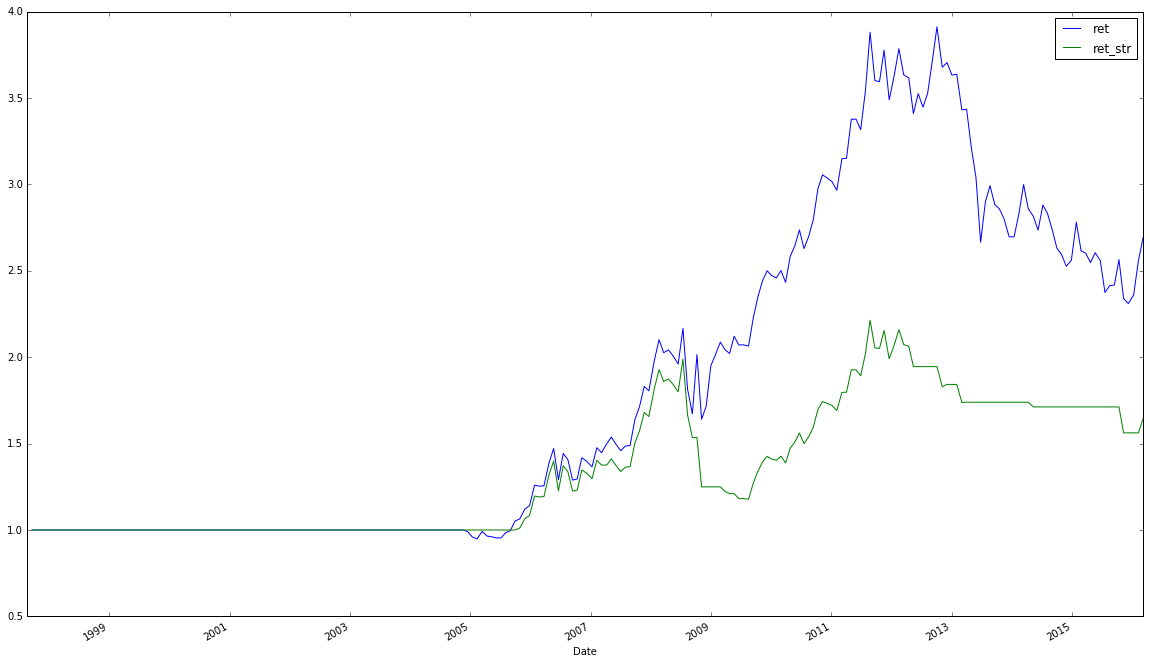

In [20]:
def filtering(data, f) :
    for i in range(len(data)) :
        if i%f == 0:
            #print i
            continue
        data.iloc[i, :] = np.NAN
    return data.dropna()

ticker = global_tickers[7]
df_spy = dp_global[:, :, 'price'][[ticker]]
df_spy_m = filtering(df_spy, 20)
df_spy_m['ma10'] = pd.rolling_mean(df_spy_m[ticker], 10)
df_spy_m['ret'] = df_spy[ticker].pct_change()

df_spy_m['ret_str'] = df_spy_m['ret'] * (df_spy_m['ma10'] > df_spy_m['ma10'].shift(1)).shift(1)
(1+df_spy_m[['ret', 'ret_str']]).cumprod().plot(figsize=[20,12])

## 策略1: 年收益如果低于（5％）则投资长期债券， 如果高于5%则投资股票

In [ ]:
ticker_bm = 'GOOG/NYSEARCA_TLT'
ticker_target = 9
df_str = pd.DataFrame()
df_str['1'] = ((df_ret_12m.iloc[:,ticker_target] > 0.05)).shift(1) * df_ret.iloc[:, ticker_target]
df_str['2'] = (df_ret_12m.iloc[:,ticker_target] < 0.05).shift(1) * df_ret[ticker_bm]
df_str['3'] = df_str['1'] + df_str['2']
df_str['target'] = df_ret.iloc[:,ticker_target]
(1+df_str).cumprod().plot(figsize=[20,10])

In [ ]:
ticker_bm = 'GOOG/NYSEARCA_TLT'
ticker_target = 2
price_target = df_m.iloc[:, ticker_target]
ret_target = df_ret.iloc[:, ticker_target]
df_str = pd.DataFrame()
df_str['1'] = ((price_target > pd.rolling_mean(price_target, 10))).shift(1) * ret_target
df_str['2'] = (price_target < pd.rolling_mean(price_target, 10)).shift(1) * df_ret[ticker_bm]
df_str['3'] = df_str['1'] + df_str['2']
df_str['target'] = ret_target
(1+df_str).cumprod().plot(figsize=[20,10])

In [ ]:
df_prices = dp[:, :, 'price']
#df_prices = df_prices['2005-01-01'::]
df_prices_m = df_prices.resample('M')

df_rets_m = df_prices_m.pct_change()
df_rets_d = df_prices.pct_change()

In [ ]:
df_prices = dp[:,:,'price']

df_m = {}
df_m['price'] = df_prices.resample('M')
df_m['ret'] = df_m['price'].pct_change()
df_m = pd.Panel(df_m)

tickers = df_m.axes[2]
moving_size = 3
ticker_bm = 'GOOG/NYSEARCA_TLT'
ticker_spy = 'GOOG/NYSE_SPY'


df_m['con_10mma'] = df_m['price'] > pd.rolling_mean(df_m['price'], 10)
df_con_mma_spy = pd.DataFrame()
for t in tickers:
    df_con_mma_spy[t] = pd.rolling_sum(df_m['ret'][t], moving_size) > \
        pd.rolling_sum(df_m['ret'][ticker_spy], moving_size)

df_m['con_mma_spy'] = df_con_mma_spy
df_m['con_3'] = df_m['ret'] > 0
df_m['con_comb'] = df_m['con_10mma'] & df_m['con_mma_spy'] & df_m['con_3']
    
df_m['ret_str1'] = df_m['con_10mma'].shift(1) * df_m['ret']
df_m['ret_str2'] = df_m['con_mma_spy'].shift(1) * df_m['ret']
df_m['ret_str3'] = df_m['con_3'].shift(1) * df_m['ret']
df_m['ret_strcomb'] = df_m['con_comb'].shift(1) * df_m['ret']

## Strategies aggregating all the ETFs which satisfy the conditions
df_strategy = pd.DataFrame()
df_strategy['count_1'] = (df_m['con_10mma'] <> 0).sum(axis=1)
df_strategy['count_1'][df_strategy['count_1'] == 0] = 1
df_strategy['str1'] = df_m['ret_str1'].sum(axis=1) / df_strategy['count_1'].shift(1)
df_strategy['count_2'] = (df_m['con_mma_spy'] <> 0).sum(axis=1)
df_strategy['count_2'][df_strategy['count_2'] == 0] = 1
df_strategy['str2'] = df_m['ret_str2'].sum(axis=1) / df_strategy['count_2'].shift(1)

df_strategy['count_3'] = (df_m['con_3'] <> 0).sum(axis=1)
df_strategy['count_3'][df_strategy['count_3'] == 0] = 1
df_strategy['str3'] = df_m['ret_str3'].sum(axis=1) / df_strategy['count_3'].shift(1)

df_strategy['count_comb'] = (df_m['con_comb'] <>0).sum(axis=1)
df_strategy['count_comb'][df_strategy['count_comb'] == 0] = 1
df_strategy['str_comb'] = df_m['ret_strcomb'].sum(axis=1) / df_strategy['count_comb'].shift(1)

In [ ]:
(1+df_strategy[['str1','str2', 'str3', 'str_comb']]).cumprod().plot(figsize=[20,12])

In [ ]:
(1+df_m['ret_str3']).cumprod().plot(figsize=[20,10])

## Momentum Strategy

In [ ]:
dp[:, :, 'price'].columns

In [ ]:
sector_tickers = [
            'GOOG/NYSEARCA_XLB',
            'GOOG/NYSEARCA_XLE', 
            'GOOG/NYSEARCA_XLF',
            'GOOG/NYSEARCA_XLI',
            'GOOG/NYSEARCA_XLK',
            'GOOG/NYSEARCA_XLP', 
            'GOOG/NYSEARCA_XLU', 
            'GOOG/NYSEARCA_XLV', 
            'GOOG/NYSEARCA_XLY', 
            'GOOG/NYSE_SPY', 
            'GOOG/NYSEARCA_TLT'
            ]


settings = Settings()
dp = TimeSeries(settings).get_agg_data(sector_tickers)
dp = dp.fillna(method='pad', axis=0)
dp = dp.fillna(method='bfill', axis=0)

dp = dp[:, '2006-01-01'::, :]

ticker_bm = 'GOOG/NYSEARCA_TLT'
ticker_spy = 'GOOG/NYSE_SPY'
    
df_avg = ETF_Momentum_Strategy(dp, ticker_bm, ticker_spy)
(1+df_avg).cumprod().plot(figsize=[20,10])

In [ ]:
micai_tickers = ['GOOG/NYSE_VWO', 
                'GOOG/NYSE_VPL', 
                'GOOG/NYSE_VGK', 
                'GOOG/NYSE_VTI',
                'GOOG/NYSE_BND', #美国债券ETF
                'GOOG/AMEX_BWX', #SPDR Barclays Intl Treasury bond etf
                'GOOG/NYSEARCA_LQD', #iShares IBoXX & Invest Grade Corp Bond 
                'GOOG/NYSEARCA_EMB', #iShares JPMorgan Emerging Mkt Bond
                'GOOG/NYSE_SPY',
                'GOOG/NYSEARCA_TLT']



settings = Settings()
dp = TimeSeries(settings).get_agg_data(micai_tickers)
dp = dp.fillna(method='pad', axis=0)
dp = dp.fillna(method='bfill', axis=0)
dp = dp[:, '2006-01-01'::, :]

ticker_bm = 'GOOG/NYSEARCA_TLT'
ticker_spy = 'GOOG/NYSE_SPY'
    
df_avg = ETF_Momentum_Strategy(dp, ticker_bm, ticker_spy)
(1+df_avg).cumprod().plot(figsize=[20,10])

In [ ]:
global_tickers = [
           #'GOOG/AMEX_EWJ', # iShares MSCI Japan ETF
           'GOOG/NYSE_IEV', # iShares Europe ETF
           'GOOG/NYSE_VWO', # Vanguard Emerging Market Stock ETF
           
           #'GOOG/NYSE_VNQ', # Vanguard MSCI US Reits
           'GOOG/NYSE_IYR', # iShares U.S. Real Estate ETF
           'GOOG/NYSE_RWX', # SPDR DJ Wilshire Intl Real Estate ETF
           
           'GOOG/NYSEARCA_TLT',  # 20 Years Treasury ETF
           'GOOG/NYSEARCA_TLH',  # 15-20 Years Treasury
           
           'GOOG/AMEX_GSG', # GSCI Commodity-Indexed Trust Fund
           'GOOG/NYSEARCA_GLD',  # SPDR Gold ETF
           'GOOG/NYSE_SPY']

micai_tickers = ['GOOG/NYSE_VWO', 
                'GOOG/NYSE_VPL', 
                'GOOG/NYSE_VGK', 
                'GOOG/NYSE_VTI',
                'GOOG/NYSE_BND', #美国债券ETF
                'GOOG/AMEX_BWX', #SPDR Barclays Intl Treasury bond etf
                #'GOOG/NYSEARCA_LQD', #iShares IBoXX & Invest Grade Corp Bond 
                'GOOG/NYSEARCA_EMB', #iShares JPMorgan Emerging Mkt Bond
                'GOOG/NYSE_SPY',
                'GOOG/NYSEARCA_TLT']


tickers = global_tickers   + micai_tickers + sector_tickers 
settings = Settings()
dp = TimeSeries(settings).get_agg_data(tickers)
#dp = dp.fillna(method='pad', axis=0)
#dp = dp.fillna(method='bfill', axis=0)
dp = dp[:, '2006-01-01'::, :]

ticker_bm = 'GOOG/NYSEARCA_TLT'
ticker_spy = 'GOOG/NYSE_SPY'
    
df_avg = ETF_Momentum_Strategy(dp, ticker_bm, ticker_spy)
(1+df_avg).cumprod().plot(figsize=[20,10])

In [ ]:
df_avg.groupby(df_avg.index.year).sum() * 100

In [ ]:
dp[:,:,'price'].resample('M').pct_change().groupby(dp[:,:,'price'].resample('M').index.year).sum().T*100

In [ ]:
import numpy as np
df_avg.mean() * 12

In [ ]:
def custom_resampler(array) :
    return array.tail(1)

df_price_m = dp[:, :,'price'].resample('20d')
df_ret_m = df_price_m.pct_change().dropna()

df_str = df_ret_m * (df_ret_m > 0).shift(1)
df_str['bm'] = df_ret_m[ticker_spy]
(1+df_str).cumprod().plot(figsize=[20, 10])

In [ ]:
df_price_m = dp[:, :,'price'].resample

In [ ]:
dp_price = dp[:, :, 'price'][tickers[2]]
#dp_price = dp_price['2005-01-01'::]

df_p = pd.DataFrame()
df_p['p'] = dp[:,:,'price'][tickers[3]]
#df_p['p2'] = dp[:,:,'price'][ticker_spy].resample('M', label='right', closed='right')
df_p['p2m'] = pd.rolling_mean(dp[:,:,'price'][ticker_spy], 20)
df_p = df_p.dropna()

def filtering(data, f) :
    for i in range(len(data)) :
        if i%f == 0:
            #print i
            continue
        data.iloc[i, :] = np.NAN
    return data.dropna()


df_p = filtering(df_p, 20)

df_r = pd.DataFrame()
df_r['p'] = df_p['p'].pct_change()
df_r['p_str'] = df_r['p'] * (df_p['p'] > df_p['p'].shift(1)).shift(1)
# df_r['p2_str'] = df_r['p'] * (df_p['p2'] > df_p['p2'].shift(1)).shift(1)
df_r['p2m_str'] = df_r['p'] * (df_p['p2m'] > df_p['p2m'].shift(1)).shift(1)
(1+df_r).cumprod().plot(figsize=[20,8])

In [ ]:
global_tickers = [
           #'GOOG/AMEX_EWJ', # iShares MSCI Japan ETF
           'GOOG/NYSE_IEV', # iShares Europe ETF
           'GOOG/NYSE_VWO', # Vanguard Emerging Market Stock ETF
           
           #'GOOG/NYSE_VNQ', # Vanguard MSCI US Reits
           'GOOG/NYSE_IYR', # iShares U.S. Real Estate ETF
           'GOOG/NYSE_RWX', # SPDR DJ Wilshire Intl Real Estate ETF
           
           'GOOG/NYSEARCA_TLT',  # 20 Years Treasury ETF
           'GOOG/NYSEARCA_TLH',  # 15-20 Years Treasury
           
           'GOOG/AMEX_GSG', # GSCI Commodity-Indexed Trust Fund
           'GOOG/NYSEARCA_GLD',  # SPDR Gold ETF
           'GOOG/NYSE_SPY']

micai_tickers = ['GOOG/NYSE_VWO', 
                'GOOG/NYSE_VPL', 
                'GOOG/NYSE_VGK', 
                'GOOG/NYSE_VTI',
                'GOOG/NYSE_BND', #美国债券ETF
                'GOOG/AMEX_BWX', #SPDR Barclays Intl Treasury bond etf
                #'GOOG/NYSEARCA_LQD', #iShares IBoXX & Invest Grade Corp Bond 
                'GOOG/NYSEARCA_EMB', #iShares JPMorgan Emerging Mkt Bond
                'GOOG/NYSE_SPY',
                'GOOG/NYSEARCA_TLT']


tickers = global_tickers  # + micai_tickers + sector_tickers 
settings = Settings()
dp = TimeSeries(settings).get_agg_data(tickers)

dp_price = dp[:, :, 'price']
dp_price = dp_price['2005-03-02'::]

#dp_price_f = dp_price.resample('20d')
dp_price_f = filtering(dp_price, 20)
dp_ret = dp_price_f.pct_change()
dp_str = dp_ret * (dp_ret > 0).shift(1)
(1+dp_str).cumprod().plot(figsize=[20, 10])

In [ ]:
dp_price = dp[:, :, 'price']
dp_price = dp_price.fillna(method='pad')
dp_price = dp_price.fillna(method='bfill')
dp_price.plot(figsize=[20,10])

In [ ]:
dp_price = dp_price['2007-03-02'::]
dp_price_f = filtering(dp_price, 20)

dp_ret = pd.DataFrame()
#dp_ret['r'] = dp_price[ticker_spy].pct_change()
dp_ret['r_f'] = dp_price_f[ticker_spy].pct_change()
dp_ret['r_str'] = dp_ret['r_f'] * (dp_ret['r_f'] > 0).shift(1)
dp_ret = dp_ret.dropna()

(1+dp_ret).cumprod().plot(figsize=[20,10])
#dp[:, :, 'price']

In [ ]:
df_r = df_p.pct_change()

df_s = df_r  * (df_r > 0).shift(1)
# df_s = df_r * (df_r > 0).shift(1)
(1+df_s).cumprod().plot()

In [36]:
t = float(range(100))
st = np.sin(pt)

TypeError: float() argument must be a string or a number

In [92]:
df_test = pd.DataFrame()
df_test['t'] = range(10000)
df_test['asset'] = np.sin(np.pi / 4000.0 * df_test['t']) + 1000
df_test['ret'] = df_test['asset'].pct_change()
df_test['ret1'] = df_test['ret'] * (df_test['ret'] > 0).shift(1)
df_test['ret2'] = df_test['ret1'] * df_test['ret1'] / df_test['ret1'].max()
df_test = df_test.set_index('t')

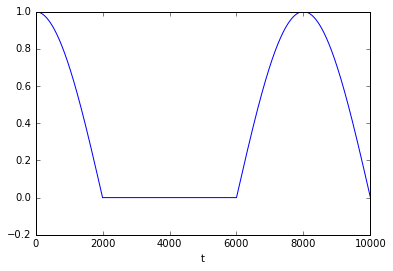

In [93]:
(df_test['ret1'] / df_test['ret1'].max()).plot()

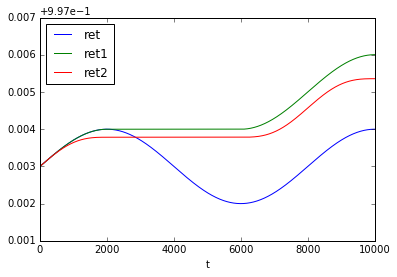

In [94]:
(1+df_test[['ret', 'ret1', 'ret2']]).cumprod().plot()